In [1]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'
fig_dir = proj_dir+'/Streambed_seepage/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel/'

In [3]:
# run_dir = 'C://WRDAPP/GWFlowModel'
# run_dir = 'F://WRDAPP/GWFlowModel'
# loadpth = run_dir +'/Cosumnes/'




loadpth =  'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage'
# model_ws = loadpth+'/data'
model_ws = loadpth+'/inset_model'

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [218]:
m_ver = '' # default no alternate output/input names
# m_ver = '_vka10'


In [310]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/grid/rm_only_grid.shp')
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs='epsg:32610')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [4]:
events = pd.read_csv(dat_dir+'event_dates.csv',index_col=0,parse_dates=['start','end']).dropna(axis=0)

events['length'] = events.end-events.start



In [216]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]

dates_per = strt_date + (m.dis.perlen.array.cumsum()-1).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
dates_stps = strt_date + (np.repeat(stplen, m.dis.nstp.array).cumsum()-1).astype('timedelta64[D]')


In [330]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

## Sensor data and XS data

In [7]:
df = pd.read_csv(dat_dir+'instream_sensor_latlong.csv',comment='#', engine='python')
df['id_num'] = df.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm = df[df.Type=='Level']
rm_sp = gpd.GeoDataFrame(rm, geometry=gpd.points_from_xy(rm.Longitude,rm.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

rm_teichert = rm_sp[rm_sp.id_num>3]


rm_xs = gpd.read_file(proj_dir+ 'rm_xs/rm_xs.shp')

In [8]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [9]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))

# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [10]:
rm_teichert['Easting'] = rm_teichert.geometry.x
rm_teichert['Northing'] = rm_teichert.geometry.y
rm_poly = rm_teichert.copy()
# buffer sensor points for joining
rm_poly.geometry = rm_poly.geometry.buffer(50)
# correspond XS to sensors
rm_elev = gpd.sjoin(xs_all, rm_poly, how='inner',lsuffix='xs', rsuffix='rm')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:786: DeprecationWarning: An exception was ignored while fetc

In [11]:
rm_elev['dist'] = np.sqrt((rm_elev.Easting_xs - rm_elev.Easting_rm)**2 + (rm_elev.Northing_xs - rm_elev.Northing_rm)**2)
mindists = rm_elev.groupby('xs_num').min().dist
# rm_elev.columns
rm_elev_final = rm_elev.set_index(['xs_num','dist']).loc[list(zip(mindists.index, mindists.values))]
# join with XS minimum and slope data
rm_elev_final = rm_elev_final.join(XSg.set_index('xs_num')[['z_m_min_cln','slope']])

# field data with measurements
field = pd.read_excel(dat_dir+'Field_measurements.xlsx',sheet_name='Summarized').rename(columns={'Site':'Sensor'})
rm_elev_final = rm_elev_final.join(field.set_index('Sensor'),on='Sensor')

# rm_elev_final['height_above_thalweg_m'] = rm_elev_final.z_m - rm_elev_final.z_m_min
rm_elev_final['height_above_thalweg_m'] = rm_elev_final['Height above thalweg (ft)']  * 0.3048
# sensor height above thalweg
rm_elev_final['sensor_height_m'] = rm_elev_final.z_m_min_cln + rm_elev_final.height_above_thalweg_m

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_584\2549232970.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  mindists = rm_elev.groupby('xs_num').min().dist


In [12]:
FLD = pd.read_csv(dat_dir+'FLD.csv', parse_dates=['DATE TIME'], na_values='---')
ANU = pd.read_csv(dat_dir+'ANU.csv', parse_dates=['DATE TIME'], na_values='---')


In [13]:
baro = pd.concat((FLD,ANU)).pivot(columns='STATION_ID',values='VALUE',index='DATE TIME')
# resample to hour for consistent units
baro = baro.resample('H').mean()
# convert from inches to meters
baro = (baro/12) * 0.3048
baro = baro.resample('15min').ffill()

In [14]:
lvl = pd.read_csv(dat_dir+'Stream_level_m_temp_C_long.csv', parse_dates=['dt'])
lvl = lvl[lvl.param=='LEVEL']
# lvl.loc[lvl.value>9,'value'] -= 9.5
# lvl = lv.pivot(columns = 'site_nam',values='value', index='dt')

# adjust level data for uniform baro pressure
lvl = lvl.pivot(columns='site_nam',values='value',index='dt')
lvl.loc[:,(lvl.mean()>9.5)] -= 9.5
lvl = lvl.melt(ignore_index=False).dropna()

# join with barometric pressure by date
lvl = lvl.join(baro, on='dt')
lvl['lvl_adj'] = lvl.value - lvl.FLD

In [15]:
sfr_dir = gwfm_dir+'/SFR_data/'
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


In [16]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]


In [235]:
grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = pd.DataFrame(grid_sfr.set_index(['row','column'])[['rchlen','strtop']])
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmd2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmd2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmd2cfs
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [236]:
sfrdf =  clean_sfr_df(model_ws)

In [225]:
sfrdf.columns
# isegs = sfrdf.segment.unique()
quants = sfrdf.Cond.quantile([0.05,0.25,0.5,0.75,0.95])
sfrdf[sfrdf.Cond > quants[0.95]].segment.unique()

array([57, 58, 59, 60])

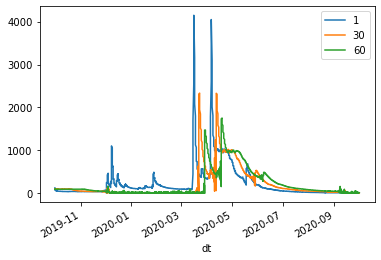

In [242]:
fig, ax = plt.subplots()
for s in [1,30,60]:
    sfrdf[sfrdf.segment==s].plot(y='Qout_cfs',ax=ax, label=s)


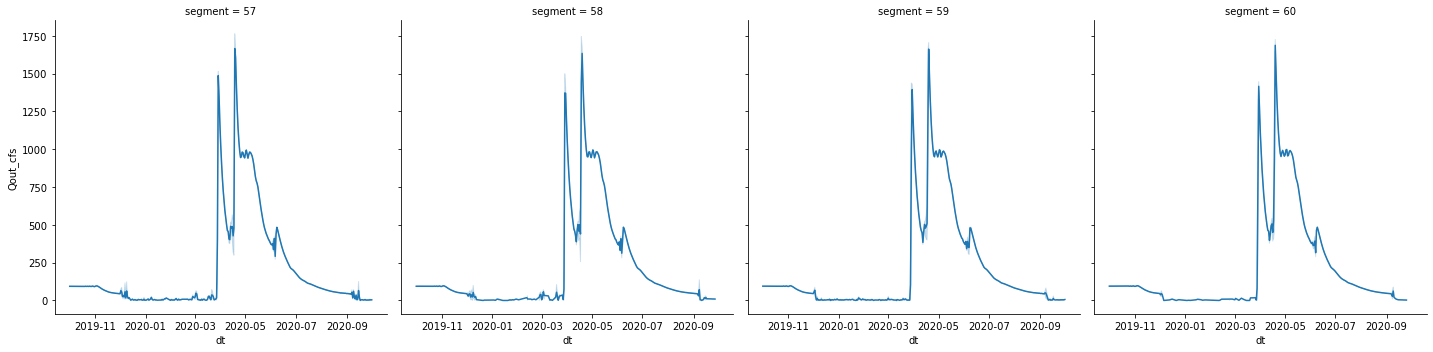

In [237]:
# downstream segments increase in number so the issues with large conductance are at the downstream end
# import seaborn as sns
sns.relplot(sfrdf[sfrdf.Cond > quants[0.95]], x='dt', y='Qout_cfs',col='segment', kind='line')

### Plot stream discretization

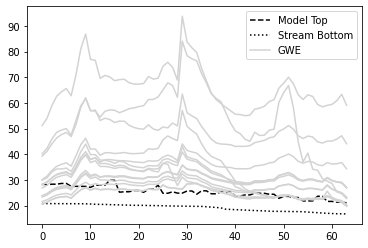

In [331]:
plt.plot(m.dis.top.array[grid_sfr.row, grid_sfr.column], label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in spd_stp[0::30]: # every 7 days 
#     spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(t)[grid_sfr.k, grid_sfr.row, grid_sfr.column]

    plt.plot(head, color='lightgray')
plt.plot(head,label = 'GWE',  color='lightgray')

plt.legend()

## Grid wide head distribution

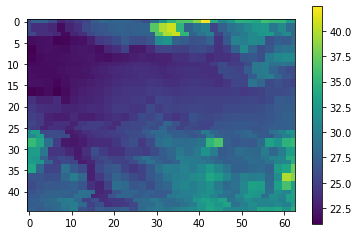

In [328]:
plt.imshow(m.dis.top.array)
plt.colorbar()

In [324]:
sfr_gpd = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.row+1, grid_sfr.column+1))]

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-pa

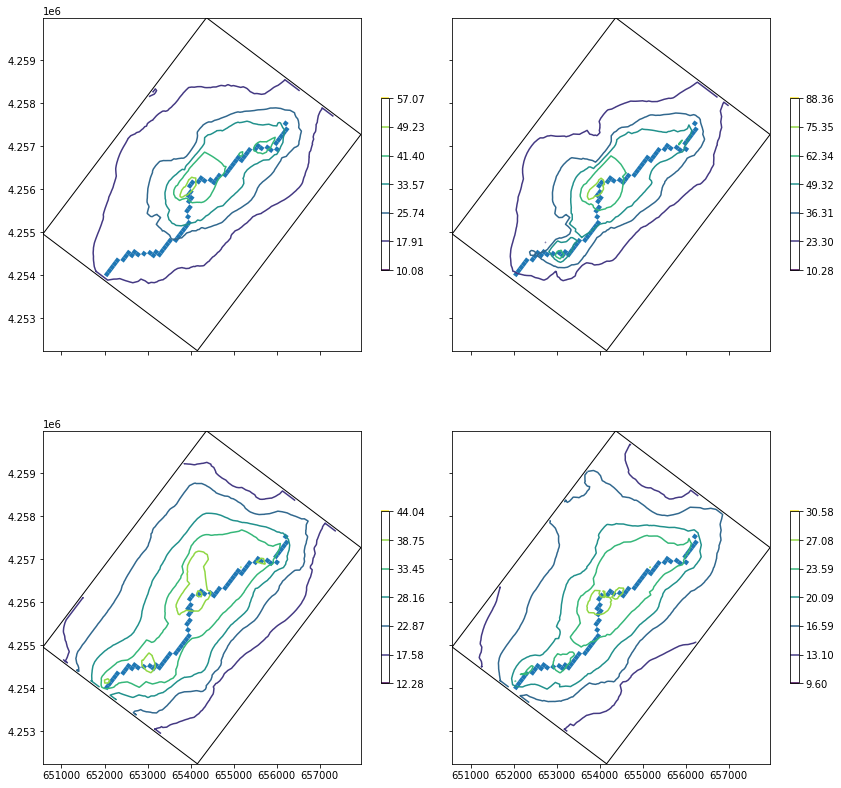

In [333]:
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))

nx = 2
ny = 2
fig,ax = plt.subplots(ny,nx, figsize=(12,12),sharex=True, sharey=True)

# fig.tight_layout()
for n,t in enumerate(spd_stp[::90][1:]):
    head = hdobj.get_data(t)[avg_sfr_lay] #m.dis.top.array - 
        
    ax_n = ax[int(n / nx), n % nx]
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    m_domain.plot(ax=ax_n,color='none')
    im = mapview.contour_array(head, masked_values=[-999.99], ax=ax_n)
    sfr_gpd.plot(ax=ax_n)
# vmin, vmax from visual inspection but could be added with code
#     im = ax_n.contour(head[avg_sfr_lay])

    ax_n.set_aspect(1)
    plt.colorbar(im, ax=ax_n, shrink = 0.4)
# fig.subplots_adjust(wspace=0.2, hspace=-.5)
fig.tight_layout()

Adding the lower GHB helps reduce mounding and creates a more realistic pattern of subsurface outflow but the gradient is still too dramatic with the mounding well over ground surface.